In [204]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score,f1_score, precision_score, recall_score

In [205]:
X = pd.read_csv('X_train_G3tdtEn.csv')
y = pd.read_csv('Y_train_2_XPXJDyy.csv')

/var/folders/vf/4bltgptd2032q3lwplnzwskh0000gp/T/ipykernel_51465/3453820476.py:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('X_train_G3tdtEn.csv')


In [206]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [207]:
X.set_index('ID', inplace=True)
y.set_index('ID', inplace=True)

In [208]:
y = y.drop(['index'], axis=1)

In [209]:
df = X.merge(y, on='ID', how='left')

In [210]:
df.shape

(92790, 146)

In [211]:
## create function to delete rows where Nb_of_items >= 3
def delete_rows(df):
    df = df[df['Nb_of_items'] < 3]
    return df

In [212]:
## Apply function delete_rows to df
df = delete_rows(df) 

In [213]:
## create function to delete columns with labels ending with numbers greater than or equal to 3
def delete_columns(df):
    columns_to_drop = []
    for column in df.columns:
        if re.search(r'\d$', column):
            # Extract the numeric part of the column label
            numeric_part = int(re.search(r'(\d+)$', column).group(1))
            # Check if the numeric part is greater than or equal to 3
            if numeric_part >= 3:
                columns_to_drop.append(column)

    # Drop the identified columns
    df = df.drop(columns=columns_to_drop, axis=1)

    return df

In [214]:
## Apply delete_columns function to df
df = delete_columns(df)

In [215]:
df.shape

(79889, 14)

In [216]:
## create function to correct orthography in item columns
def correct_orthography(df):
    for column in df.columns:
        # Check if the column contains string values
        if df[column].dtype == 'O':  # 'O' represents object dtype (usually strings)
            # Apply corrections only to string columns
            df[column] = df[column].str.replace(',', '')
            df[column] = df[column].str.replace(' &', '')
    return df

In [217]:
df = correct_orthography(df)

In [218]:
## Replace nan values in numerical columns with 0 with simpleimputer
numerical_columns = ['cash_price' + str(i) for i in range(1, 3)] + ['Nbr_of_prod_purchas' + str(i) for i in range(1, 3)]
## use simpleimputer
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

In [219]:
def replace_nan(df, column, replacement_value):
    df[column] = df[column].fillna(replacement_value)

# Utilisation de la fonction pour 'item2'
replace_nan(df, 'item2', 'no_item2')

# Utilisation de la fonction pour 'model2'
replace_nan(df, 'model2', 'no_model2')

# Utilisation de la fonction pour 'make2'
replace_nan(df, 'make2', 'no_make2')

In [220]:
df.head(1)

,item1,item2,cash_price1,cash_price2,make1,make2,model1,model2,goods_code1,goods_code2,Nbr_of_prod_purchas1,Nbr_of_prod_purchas2,Nb_of_items,fraud_flag
ID,,,,,,,,,,,,,,
85517,COMPUTERS,no_item2,889.0,0.0,APPLE,no_make2,2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 ...,no_model2,NaN,NaN,1.0,0.0,1.0,0


In [221]:
## Create function to compute total_cash_price and total_Nbr_of_prod_purchas
def compute_totals(df):
    df['total_cash_price'] = df['cash_price1'] + df['cash_price2']
    df['total_Nbr_of_prod_purchas'] = df['Nbr_of_prod_purchas1'] + df['Nbr_of_prod_purchas2']
    return df

In [222]:
df = compute_totals(df)

In [223]:
df.shape

(79889, 16)

In [224]:
## Create function to compute the mean(average) of cash_price per product purchased

def compute_ratios(df):
    df['mean_product_cash_price'] = df['total_cash_price'] / df['total_Nbr_of_prod_purchas']

    return df

In [225]:
df = compute_ratios(df)

In [226]:
df.shape

(79889, 17)

In [227]:
X_baskets = df

In [228]:
X_baskets.to_csv('X_baskets.csv')

In [229]:
## Create function to store unique values for columns items and makes in df in lists items and makes
def get_unique_values(df, columns):
    # Use a list comprehension to extract unique values from each specified column
    unique_values_list = [pd.unique(df[col]) for col in columns]

    # Flatten the list of unique values (if you want a single list of all unique values)
    all_unique_values = [value for sublist in unique_values_list for value in sublist]

    # To get unique values only once without duplicates, you can use the set() function
    unique_values = set(all_unique_values)

    return list(unique_values)

# Apply fucntion
make_columns = ['make1', 'make2']
item_columns = ['item1', 'item2']

makes = get_unique_values(df, make_columns)
items = get_unique_values(df, item_columns)

In [230]:
len(makes)

325

In [231]:
len(items)

109

In [232]:
def compute_n_category(df: pd.DataFrame, category:str) -> pd.Series:
    return df.isin([category]).sum(axis=1).rename(f"n_{category}")

processed = pd.concat([compute_n_category(df[[col for col in df.columns if "item" in col]], item) for item in items], axis=1, join='outer')

In [233]:
processed.shape

(79889, 109)

In [234]:
def compute_n_make(df: pd.DataFrame, make:str) -> pd.Series:
    return df.isin([make]).sum(axis=1).rename(f"n_{make}")

processed2 = pd.concat([compute_n_make(df[[col for col in df.columns if "make" in col]], make) for make in makes], axis=1, join='outer')


In [235]:
processed2.shape

(79889, 325)

In [236]:
df_categorized = pd.concat([processed, processed2], axis=1)

In [237]:
df_categorized.shape

(79889, 434)

In [238]:
df_bnp = pd.concat([df, df_categorized], axis=1)

In [239]:
df_bnp.shape

(79889, 451)

In [240]:
df_bnp_for_model = bnp = df_bnp.drop(['item1', 'item2', 'make1', 'make2', 'model1', 'model2', 'goods_code1', 'goods_code2', 'cash_price1', 'cash_price2'], axis=1)

In [241]:
df_bnp_for_model.shape

(79889, 441)

In [242]:
df_bnp_for_model.head(1)

,Nbr_of_prod_purchas1,Nbr_of_prod_purchas2,Nb_of_items,fraud_flag,total_cash_price,total_Nbr_of_prod_purchas,mean_product_cash_price,n_OUTDOOR FURNITURE,n_KITCHEN UTENSILS GADGETS,n_TELEPHONES FAX MACHINES TWO-WAY RADIOS,n_WARRANTY,n_LINGERIE HOISERY,n_HOME OFFICE,n_GIRLSWEAR,n_GARDENING EQUIPMENT,n_PRINTERS SCANNERS,n_WOMEN S FOOTWEAR,n_DECORATING,n_BEDROOM FURNITURE,n_THEMED GIFTS,n_HOT DRINK PREPARATION,n_GREETING CARDS PERSONALISED STATIONERY,n_APPLE S,n_BATHROOM ACCESSORIES,n_CARPETS RUGS FLOORING,n_COMPUTERS,n_STORAGE ORGANISATION,n_APPLE PRODUCTDESCRIPTION,n_CHILDREN S FOOTWEAR,n_MAKEUP,n_COOKING APPLIANCES,n_IMAGING EQUIPMENT,n_BATH LINEN,n_BLANK MEDIA MEDIA STORAGE,n_IMAGING ACCESSORIES,n_HEATING COOLING APPLIANCES,n_FITTED KITCHENS,n_WOMEN S CLOTHES,n_JEWELLERY WATCHES,n_FRAGRANCE,n_FOOD STORAGE,n_BABY FEEDING,n_GIFT FOOD DRINK,n_PARTY DECORATIONS,n_BOYSWEAR,n_DECORATIVE ACCESSORIES,n_TELEPHONE ACCESSORIES,n_MEN S NIGHTWEAR,n_BATHROOM FIXTURES,n_MEN S FOOTWEAR,n_BABY CHILD TRAVEL,n_6 SPACE GREY 32GB,n_NURSERY FURNITURE,n_BAGS WALLETS ACCESSORIES,n_AUDIO ACCESSORIES,n_COOKWARE,n_NURSERY ACCESSORIES,n_GAMING,n_POWER BATTERIES,n_SUNGLASSES READING GLASSES,n_FOOD PREPARATION,n_TOYS,n_CHRISTMAS DECORATIONS,n_FULFILMENT CHARGE,n_LUGGAGE,n_BABYWEAR,n_BARBECUES ACCESSORIES,n_BED LINEN,n_PICNICWARE,n_STANDS BRACKETS,n_MEN S ACCESSORIES,n_WOMEN S NIGHTWEAR,n_no_item2,n_HOME AND PERSONAL SECURITY,n_SCHOOLWEAR,n_LAUNDRY CLOTHESCARE,n_BATH BODYCARE,n_BABY PLAY EQUIPMENT,n_VIDEOS DVD DIGITAL EQUIPMENT,n_WINDOW DRESSING,n_WOMEN S ACCESSORIES,n_BARWARE,n_SERVICE,n_BABY CHANGING,n_PRODUCT,n_LIGHTING,n_TABLEWARE,n_MEN S UNDERWEAR SOCKS,n_COMPUTER SOFTWARE,n_HP ELITEBOOK 850V6,n_FACIAL SKINCARE,n_DRESSMAKING,n_MENS UNDERWEAR SOCKS,n_GIFT WRAP,n_CRAFT,n_HOUSEHOLD CLEANING,n_OUTDOOR ACCESSORIES,n_TELEVISIONS HOME CINEMA,n_LIVING DINING FURNITURE,n_MEN S CLOTHES,n_CHILDREN S ACCESSORIES,n_UNKNOWN,n_CABLES ADAPTERS,n_DOOR FURNITURE,n_COMPUTER PERIPHERALS ACCESSORIES,n_KITCHEN STORAGE,n_HEALTH BEAUTY ELECTRICAL,n_SOFT FURNISHINGS,n_BAGS CARRY CASES,n_HI-FI,n_COMPUTER NETWORKING,n_WOMENS CLOTHES,n_AERIALS REMOTE CONTROLS,n_KITCHEN ACCESSORIES,n_STATIONERY SUNDRIES,n_MENS CLOTHES,n_DIPTYQUE,n_BRAUN,n_EMILE ET ROSE,n_MARGO SELBY,n_STOKKE,n_RH,n_OCULUS,n_WHITTARD,n_MAXI-COSI,n_DELL,n_NORTON,n_BT,n_NUNA,n_THOMAS KENT,n_ULTIMATE EARS,n_MICROSOFT,n_ACQUA DI PARMA,n_BOSE,n_NIELSEN,n_ROYALCRAFT,n_LEVI S,n_VITRA,n_HOTEL CHOCOLAT,n_BAY LIGHTING,n_TURTLE MAT,n_CONTENT BY TERENCE CONRAN,n_BARLOW TYRIE,n_EMMA,n_CLINIQUE,n_OYOY,n_SUNCAST,n_INNOVATION LIVING,n_BELKIN,n_CREED,n_SWYFT,n_CHARLOTTE TILBURY,n_WER,n_SPECK,n_SAGE,n_KETTLER,n_RTA,n_TOM FORD,n_CRICUT,n_CYBEX,n_KENWOOD,n_HERSCHEL SUPPLY CO,n_DISNEY,n_MORRIS CO.,n_DESIGN PROJECT BY RETAILER,n_ARMANI EXCHANGE,n_AVF,n_MARSHALL,n_SCOTCH SODA,n_D R,n_DUNE,n_BIRKENSTOCK,n_LAY-Z-SPA,n_JABRA,n_THERMOS,n_AEG,n_LG OUTDOOR,n_SCALEXTRIC,n_ANDA SEAT,n_CASE,n_SOFI,n_SWEATY BETTY,n_BIG GREEN EGG,n_PHASE EIGHT,n_MORRIS CO,n_GALLERY DIRECT,n_BROTHER,n_HAVAIANAS,n_THE FINE BEDDING COMPANY,n_COCCINELLE,n_SAMSONITE,n_LOUIS DE POORTERE,n_EVA SOLO,n_OWLET,n_4 SEASONS OUTDOOR,n_SENNHEISER,n_GOOCH LUXURY,n_FRANKE,n_CALEX,n_BAJEN,n_EASIGRASS,n_HERMAN MILLER,n_HUMANSCALE,n_CANON,n_NEW BALANCE,n_LIZ EARLE,n_MULBERRY,n_RODIAL,n_MANGO,n_UMBRA,n_WEDGWOOD,n_BAR BESPOKE,n_JELLY BELLY,n_STRING,n_ROMO,n_LOGITECH,n_HARLEQUIN,n_INGENUITY,n_TED BAKER,n_TOMMEE TIPPEE,n_NORDLUX,n_SIMBA,n_DUNLOPILLO,n_MICRO SCOOTERS,n_EPSON,n_LE IRWIN,n_BEURER,n_GARMIN,n_FIAM,n_SANDERSON,n_BABYZEN,n_MORPHY RICHARDS,n_FRENCH CONNECTION,n_UPPABABY,n_VOYAGE,n_AURORA WORLD,n_PHILIPS,n_SONY,n_G PLAN VINTAGE,n_CRANE GARDEN BUILDINGS,n_WROUGHT IRON AND BRASS BED CO,n_MAGFORMERS,n_LUMIE,n_COLE SON,n_DURESTA,n_NAIM,n_RETAILER,n_TECHLINK,n_JOSEPH JOSEPH,n_RONHILL,n_SERIOUS READERS,n_RUCOMFY,n_TETRAD,n_SN Z,n_IVYLINE,n_FALLEN FRUITS,n_POTTERY BARN KIDS,n_WANDERLUST CO,n_ERCOL FOR RETAILER,n_GOOGLE,n_SIMPLEHUMAN,n_COCOBA,n_BRITAX,n_FARMERS COTTAGE,n_INSTANT POT,n_ONE

In [243]:
X1 = bnp.drop(['fraud_flag'], axis=1)
y1 = bnp['fraud_flag']

In [244]:
rus = RandomUnderSampler(sampling_strategy=0.15,random_state=0)
X_resampled, y_resampled = rus.fit_resample(X1, y1)

In [245]:
X_resampled.shape, y_resampled.shape

((9238, 440), (9238,))

In [246]:
y_resampled.value_counts()

fraud_flag
0    8033
1    1205
Name: count, dtype: int64

In [247]:
## split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

In [248]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7390, 440), (1848, 440), (7390,), (1848,))

In [249]:
## Save X_test in a csv file as 'transactions_waiting.csv'
X_test.to_csv('transactions_waiting.csv')

In [250]:
## Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [251]:
#### Gridsearch for RandomForestClassifier
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [20, 25, 30],
    'max_depth': [None, 20, 25]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1')

# Fit the GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Access the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'n_estimators': 25}


In [252]:
#Best parameters RandomForestClassifier
rf = RandomForestClassifier(max_depth=None, n_estimators=25)
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_pred = rf.predict(X_test_scaled)

In [253]:
y_test.shape

(1848,)

In [254]:
y_test.value_counts(normalize=True)

fraud_flag
0    0.869589
1    0.130411
Name: proportion, dtype: float64

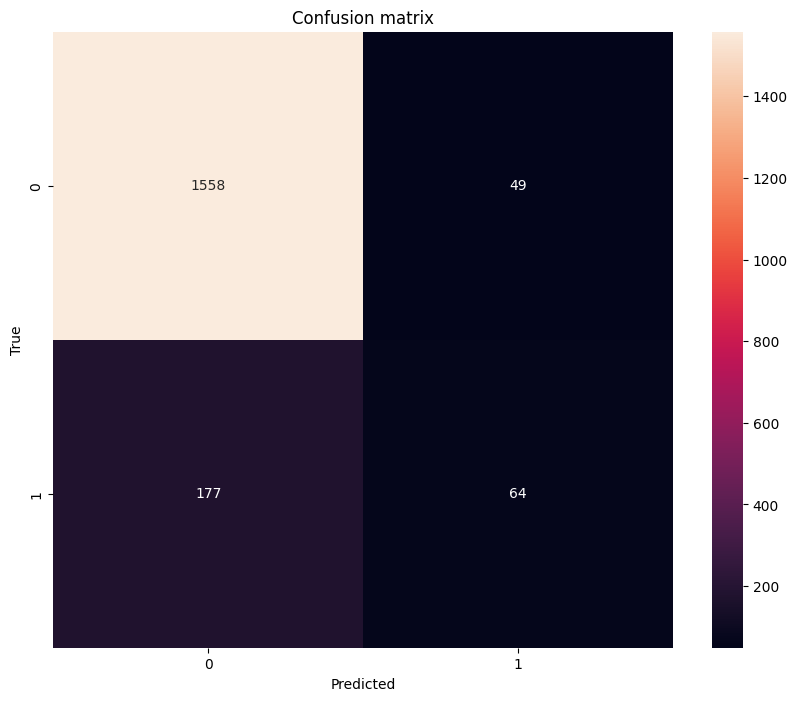

In [255]:
## plot confusion matrix with sns
confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.show()

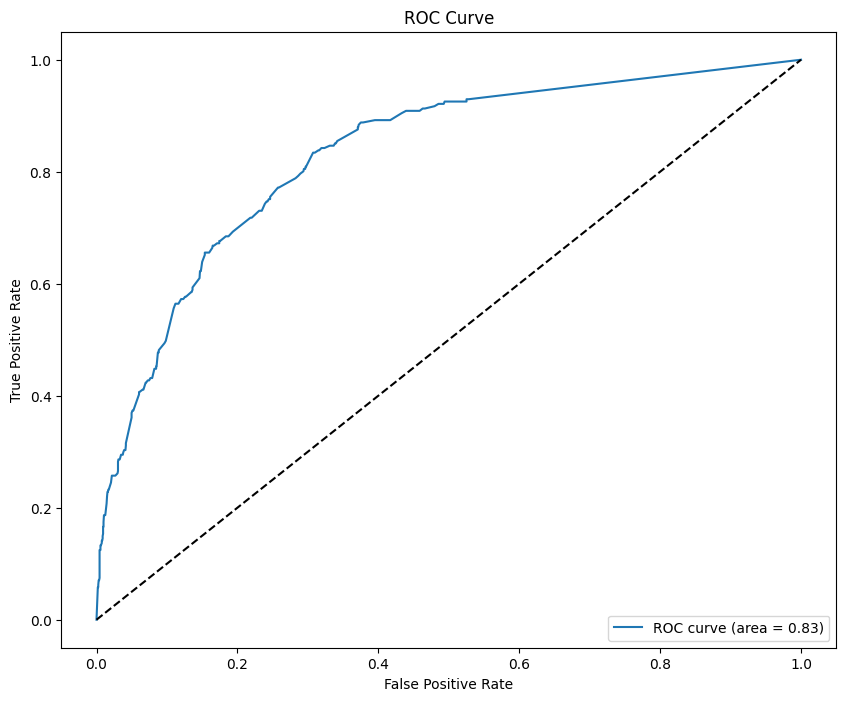

In [260]:
### plot roc curve
y_train_pred_proba = rf.predict_proba(X_train_scaled)[:, 1]
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [262]:
#### plot PR AUC curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_proba)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.47


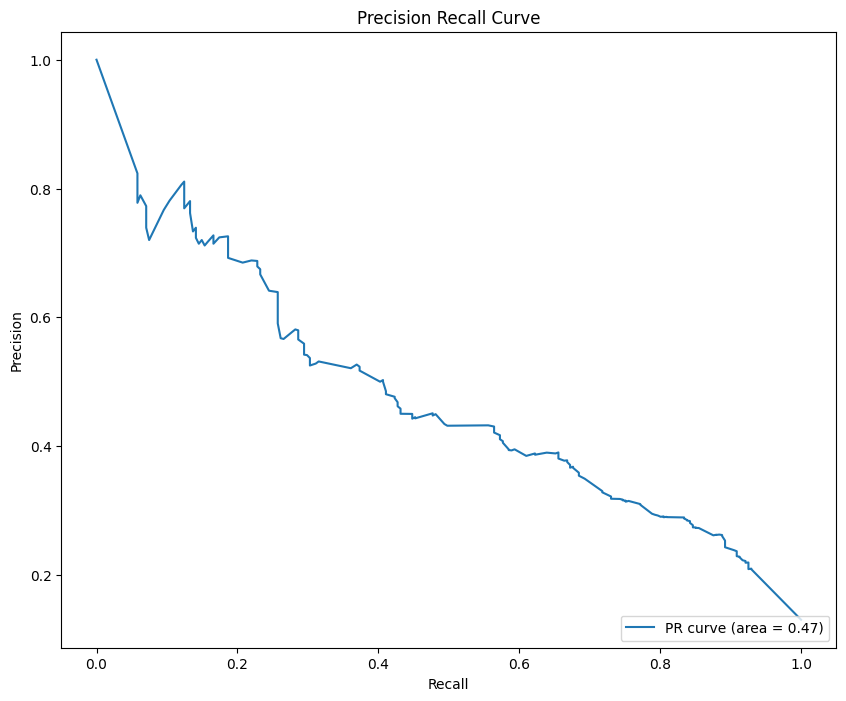

In [263]:
#### plot PR AUC curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label="PR curve (area = %0.2f)" % average_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend(loc="lower right")
plt.show()

In [266]:
## Proba of fraud for each input
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

In [267]:
y_pred_proba

array([0.38537475, 0.        , 0.3684538 , ..., 0.4       , 0.12768696,
       0.33642265])

In [268]:
## convert y_pred_proba and y_test to dataframes y_pred_proba_df and y_test_df
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=['fraud_probability'])
y_test_df = pd.DataFrame(y_test, columns=['fraud_flag'])

In [269]:
### pourcentage fraud
y_test_df.fraud_flag.value_counts(normalize=True)*100

fraud_flag
0    86.958874
1    13.041126
Name: proportion, dtype: float64

In [270]:
y_pred_proba_df.head(3)

,fraud_probability
0,0.385375
1,0.000000
2,0.368454


In [271]:
y_pred_proba_df.shape

(1848, 1)

In [272]:
type(X_test)

pandas.core.frame.DataFrame

In [273]:
y_pred_proba_df = pd.concat([X_test.reset_index()['ID'], y_pred_proba_df], axis=1)

In [274]:
y_pred_proba_df.head(5)

,ID,fraud_probability
0,61727,0.385375
1,79589,0.000000
2,79038,0.368454
3,8206,0.113903
4,67201,0.151254


In [275]:
## save y_pred_proba_df in a csv file as 'transactions_waiting_predictions.csv'
y_pred_proba_df.to_csv('transactions_waiting_predictions.csv')